# PI-II: Catboost RMSEWithUncertainty

An example of fitting Catboost using RMSEWithUncertainty loss to estimate prediction intervals.

Starter script for the [Prediction interval competition II: House price](https://www.kaggle.com/competitions/prediction-interval-competition-ii-house-price/overview) competition.

Based on @Raddar's [catboost-uncertainty](https://www.kaggle.com/code/raddar/catboost-uncertainty)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from pathlib import Path
from sklearn import preprocessing
from catboost import Pool, CatBoostRegressor

import matplotlib.pyplot as plt
from plotnine import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Competition variables.
base_path = Path('/kaggle/input/prediction-interval-competition-ii-house-price')
alpha = 0.1  # the specified competition alpha (i.e., 90% coverage)

In [3]:
def winkler_score(y_true, lower, upper, alpha=0.1, return_coverage=False):
    """Compute the Winkler Interval Score for prediction intervals.

    Args:
        y_true (array-like): True observed values.
        lower (array-like): Lower bounds of prediction intervals.
        upper (array-like): Upper bounds of prediction intervals.
        alpha (float): Significance level (e.g., 0.1 for 90% intervals).
        return_coverage (bool): If True, also return empirical coverage.

    Returns:
        score (float): Mean Winkler Score.
        coverage (float, optional): Proportion of true values within intervals.
    """
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)

    width = upper - lower
    penalty_lower = 2 / alpha * (lower - y_true)
    penalty_upper = 2 / alpha * (y_true - upper)

    score = width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)

In [4]:
base_path = Path('/kaggle/input/prediction-interval-competition-ii-house-price')

TARGET_NAMES = ['sale_price']
TARGET_NAME = 'sale_price'

test_data = pd.read_csv(base_path / 'test.csv')
train_data = pd.read_csv(base_path / 'dataset.csv')


cat_cols = [
    'sale_warning',
    'join_status',
    'city',
    'zoning',
    'subdivision',
    'submarket'
]

def fe(df):
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_date_year'] = df['sale_date'].dt.year
    df['sale_date_week'] = df["sale_date"].dt.isocalendar().week
    for col in cat_cols:
        col_series = df[col].fillna('#NA#')
        mapping = col_series.value_counts().to_dict()
        code_as = 0
        for i, key in enumerate(reversed(mapping)):
            if mapping[key] < 1:
                mapping[key] = -1 # rare or noise!
            else:
                mapping[key] = code_as
                code_as += 1
        df[col] = col_series.map(mapping)
        #df[col] = df[col].astype('category')
    return df


df_all = fe(pd.concat([train_data, test_data]))

train_data = df_all.query(f'~{TARGET_NAME}.isna()').reset_index(drop=True)
test_data = df_all.query(f'{TARGET_NAME}.isna()').reset_index(drop=True)
df_all = None 

features = sorted(set(test_data.columns) - set(['id', 'sale_date', TARGET_NAME]))

In [5]:
train_data[features].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
area,200000.0,48.644215,27.132002,1.0,26.0,48.0,71.0,100.0
bath_3qtr,200000.0,0.494115,0.638183,0.0,0.0,0.0,1.0,8.0
bath_full,200000.0,1.579735,0.672685,0.0,1.0,2.0,2.0,9.0
bath_half,200000.0,0.49302,0.525635,0.0,0.0,0.0,1.0,12.0
beds,200000.0,3.41939,0.897639,0.0,3.0,3.0,4.0,14.0
city,200000.0,34.097305,7.456563,0.0,31.0,37.0,40.0,40.0
condition,200000.0,3.515745,0.704148,1.0,3.0,3.0,4.0,5.0
fbsmt_grade,200000.0,2.811045,3.556495,0.0,0.0,0.0,7.0,13.0
gara_sqft,200000.0,274.15147,288.338763,0.0,0.0,240.0,480.0,4404.0
garb_sqft,200000.0,80.32632,180.13173,0.0,0.0,0.0,0.0,12740.0


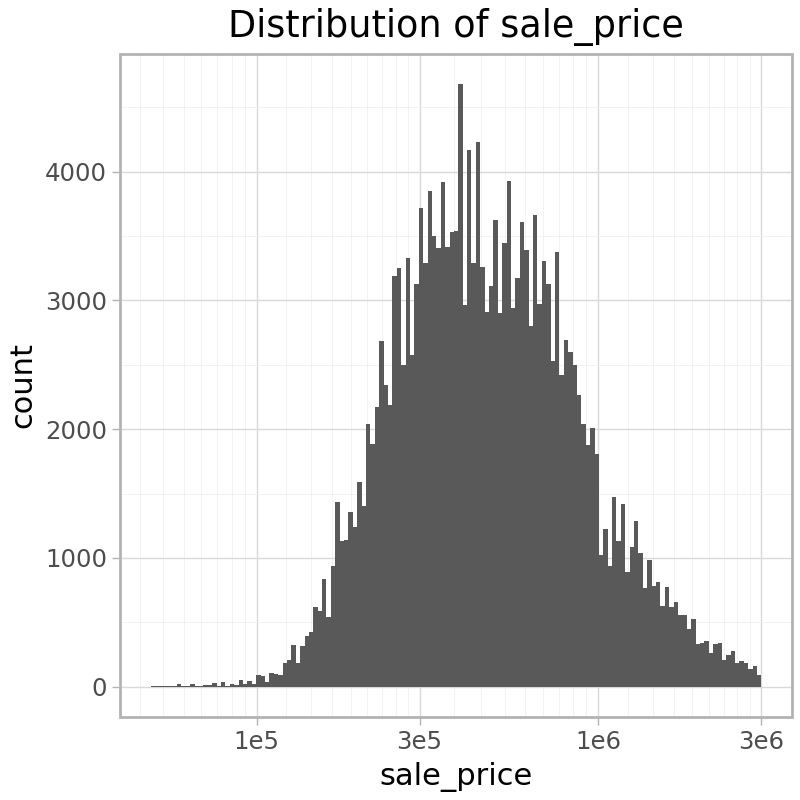

In [6]:
display(
    ggplot(train_data, aes(x=TARGET_NAME)) 
    + theme_light()
    + theme(figure_size=(4, 4))
    + geom_histogram() 
    + scale_x_log10()
    + labs(title=f'Distribution of {TARGET_NAME}'))

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 49 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                200000 non-null  int64         
 1   sale_date         200000 non-null  datetime64[ns]
 2   sale_price        200000 non-null  float64       
 3   sale_nbr          157818 non-null  float64       
 4   sale_warning      200000 non-null  int64         
 5   join_status       200000 non-null  int64         
 6   join_year         200000 non-null  int64         
 7   latitude          200000 non-null  float64       
 8   longitude         200000 non-null  float64       
 9   area              200000 non-null  int64         
 10  city              200000 non-null  int64         
 11  zoning            200000 non-null  int64         
 12  subdivision       200000 non-null  int64         
 13  present_use       200000 non-null  int64         
 14  land

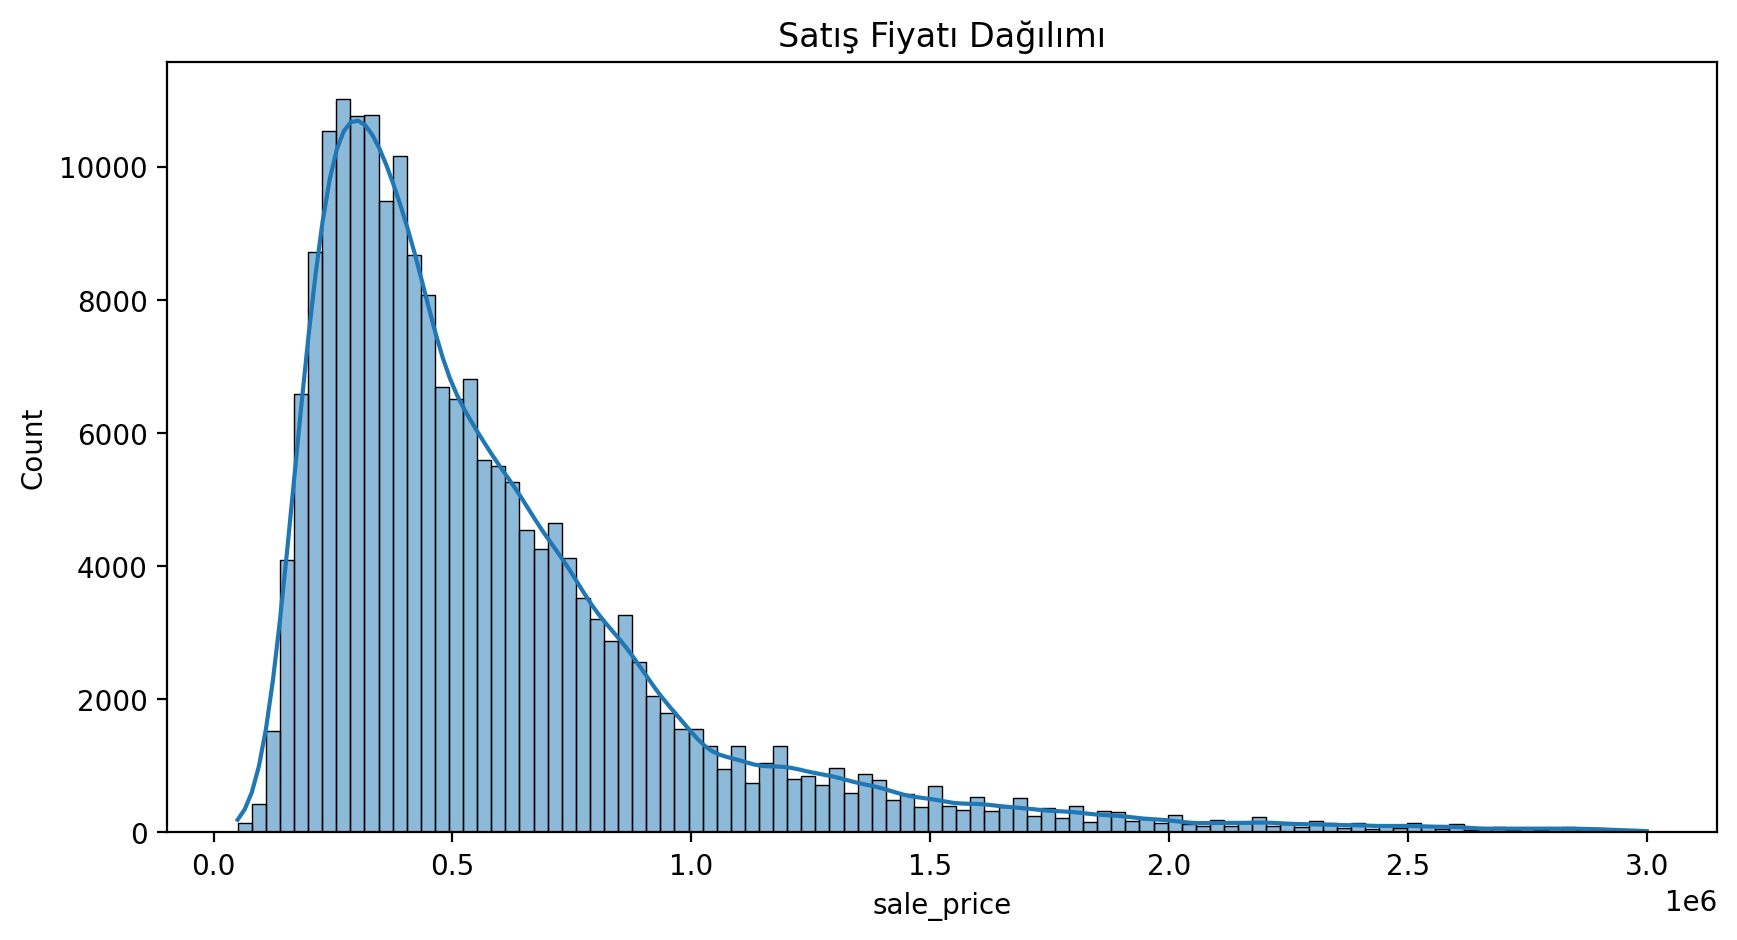

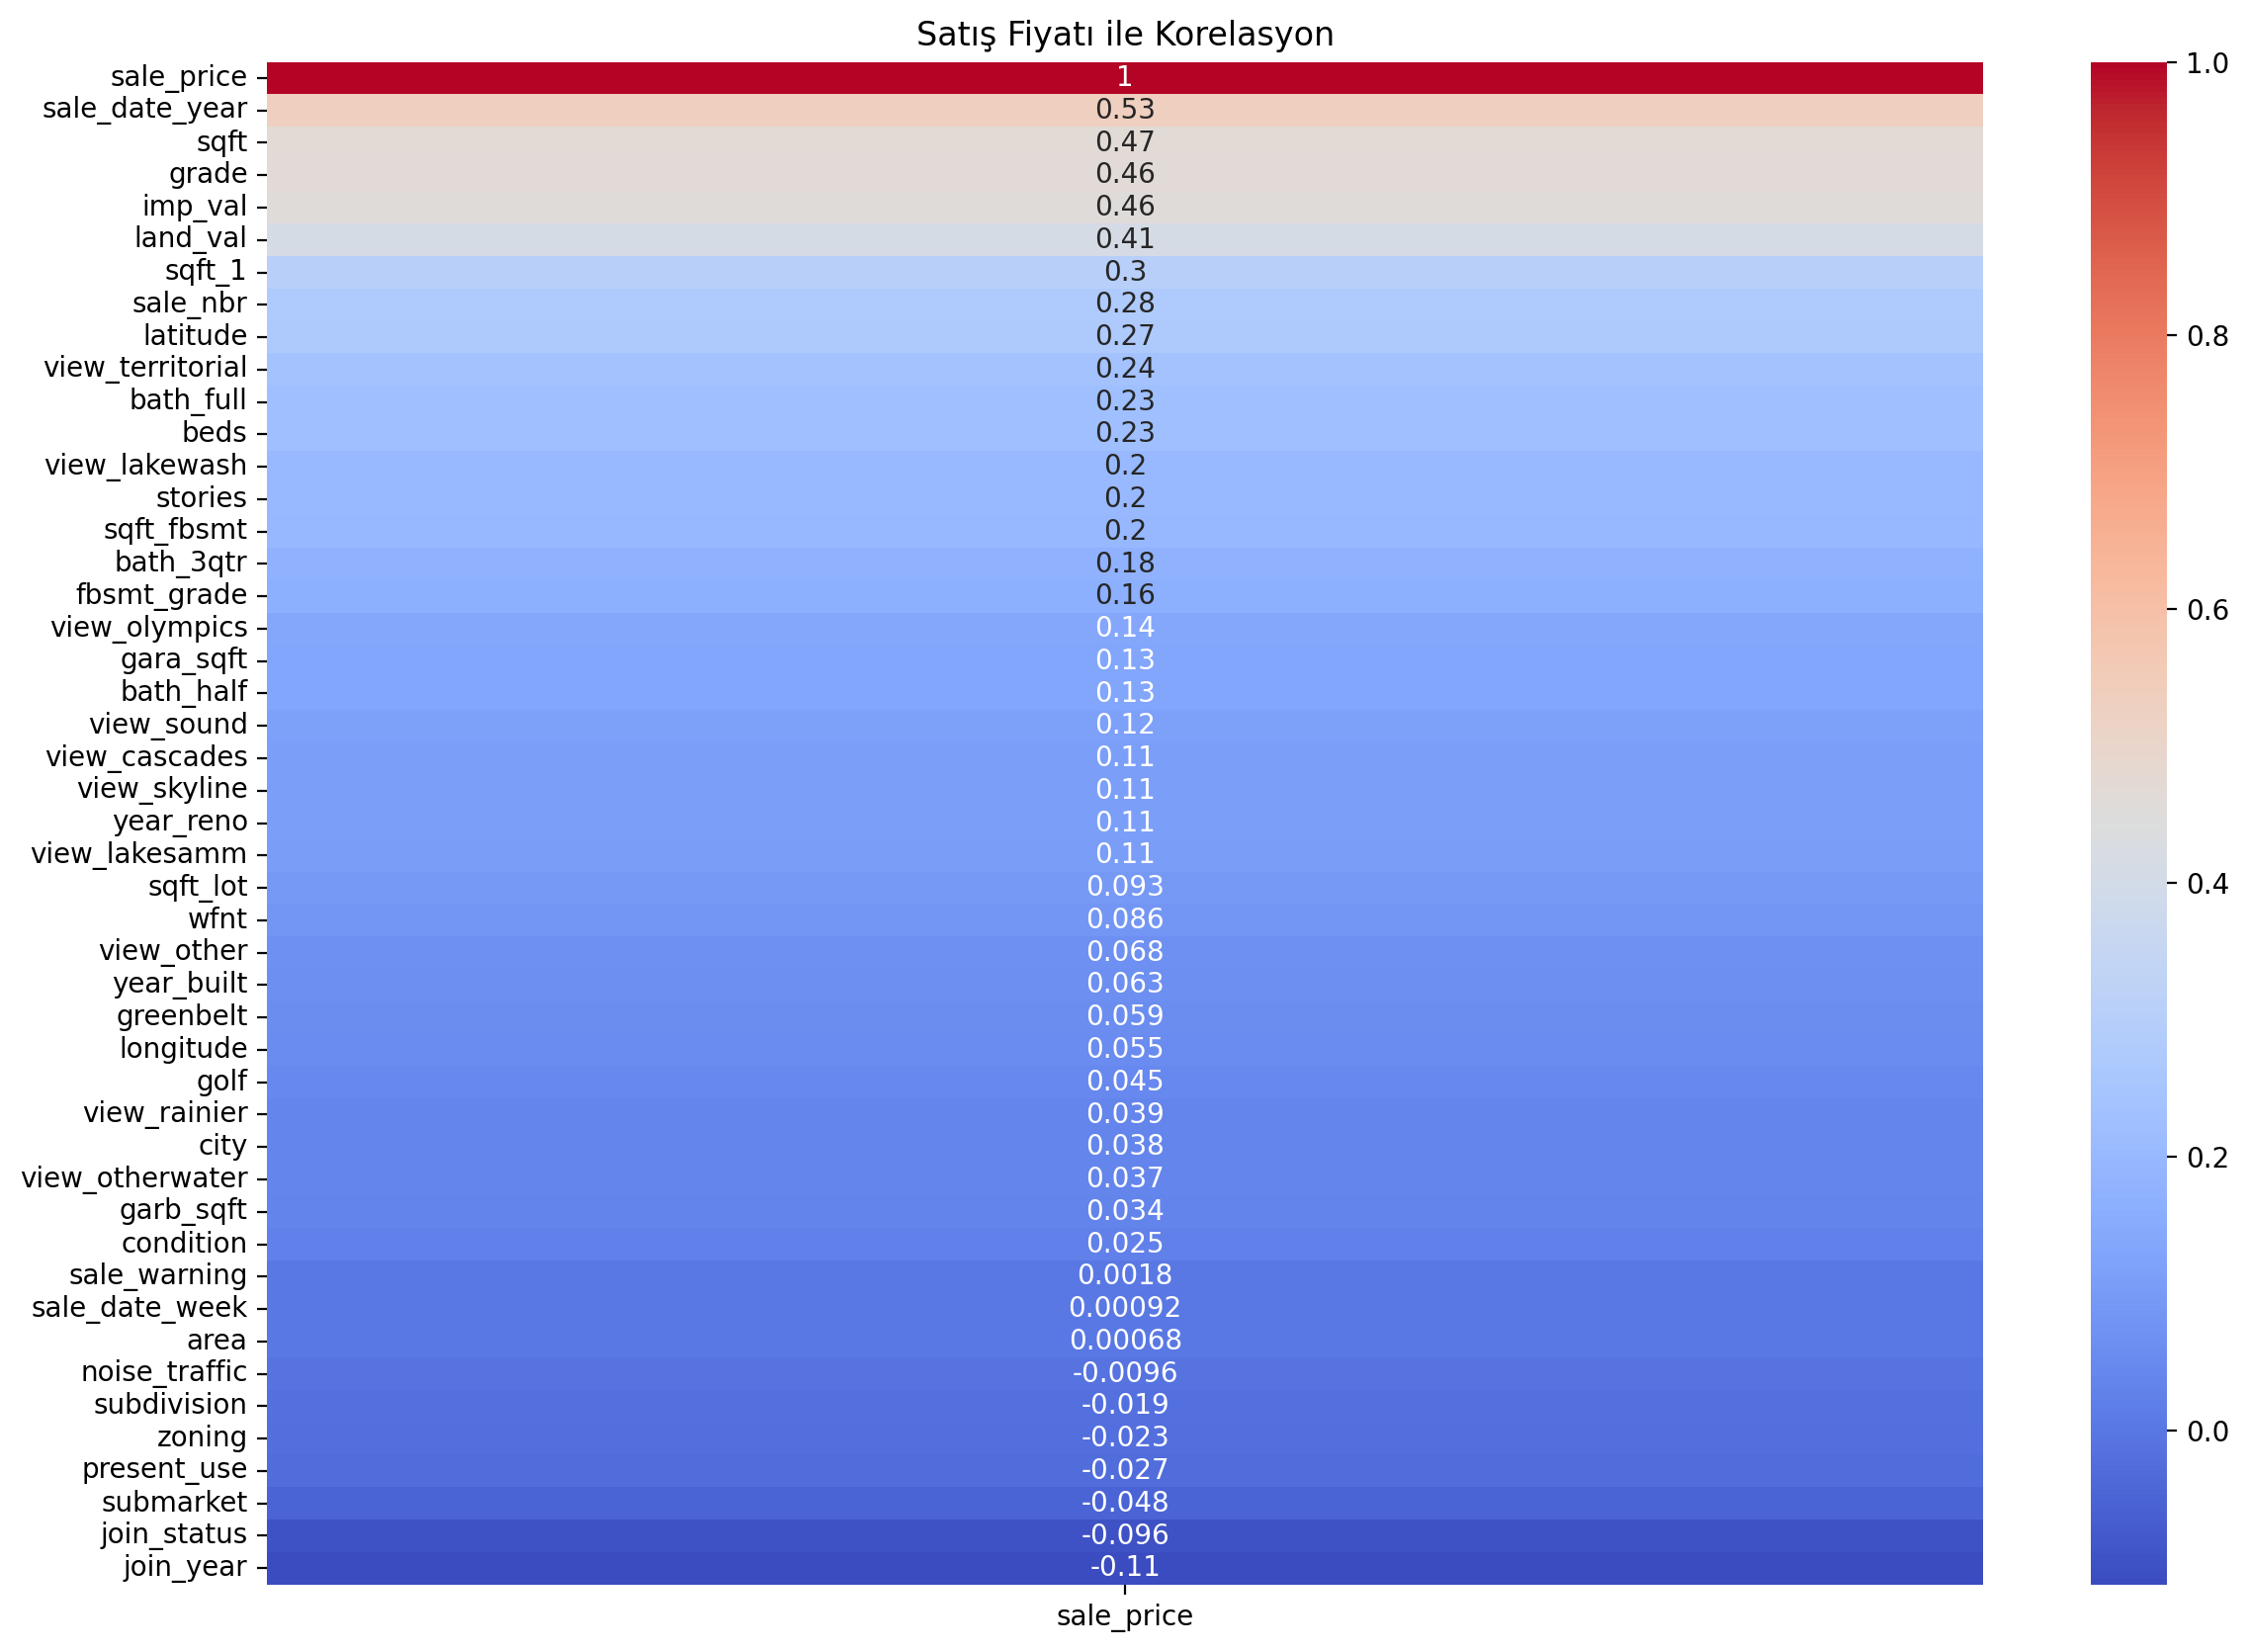

<Axes: title={'center': 'Aylık Ortalama Satış Fiyatı'}, xlabel='sale_date'>

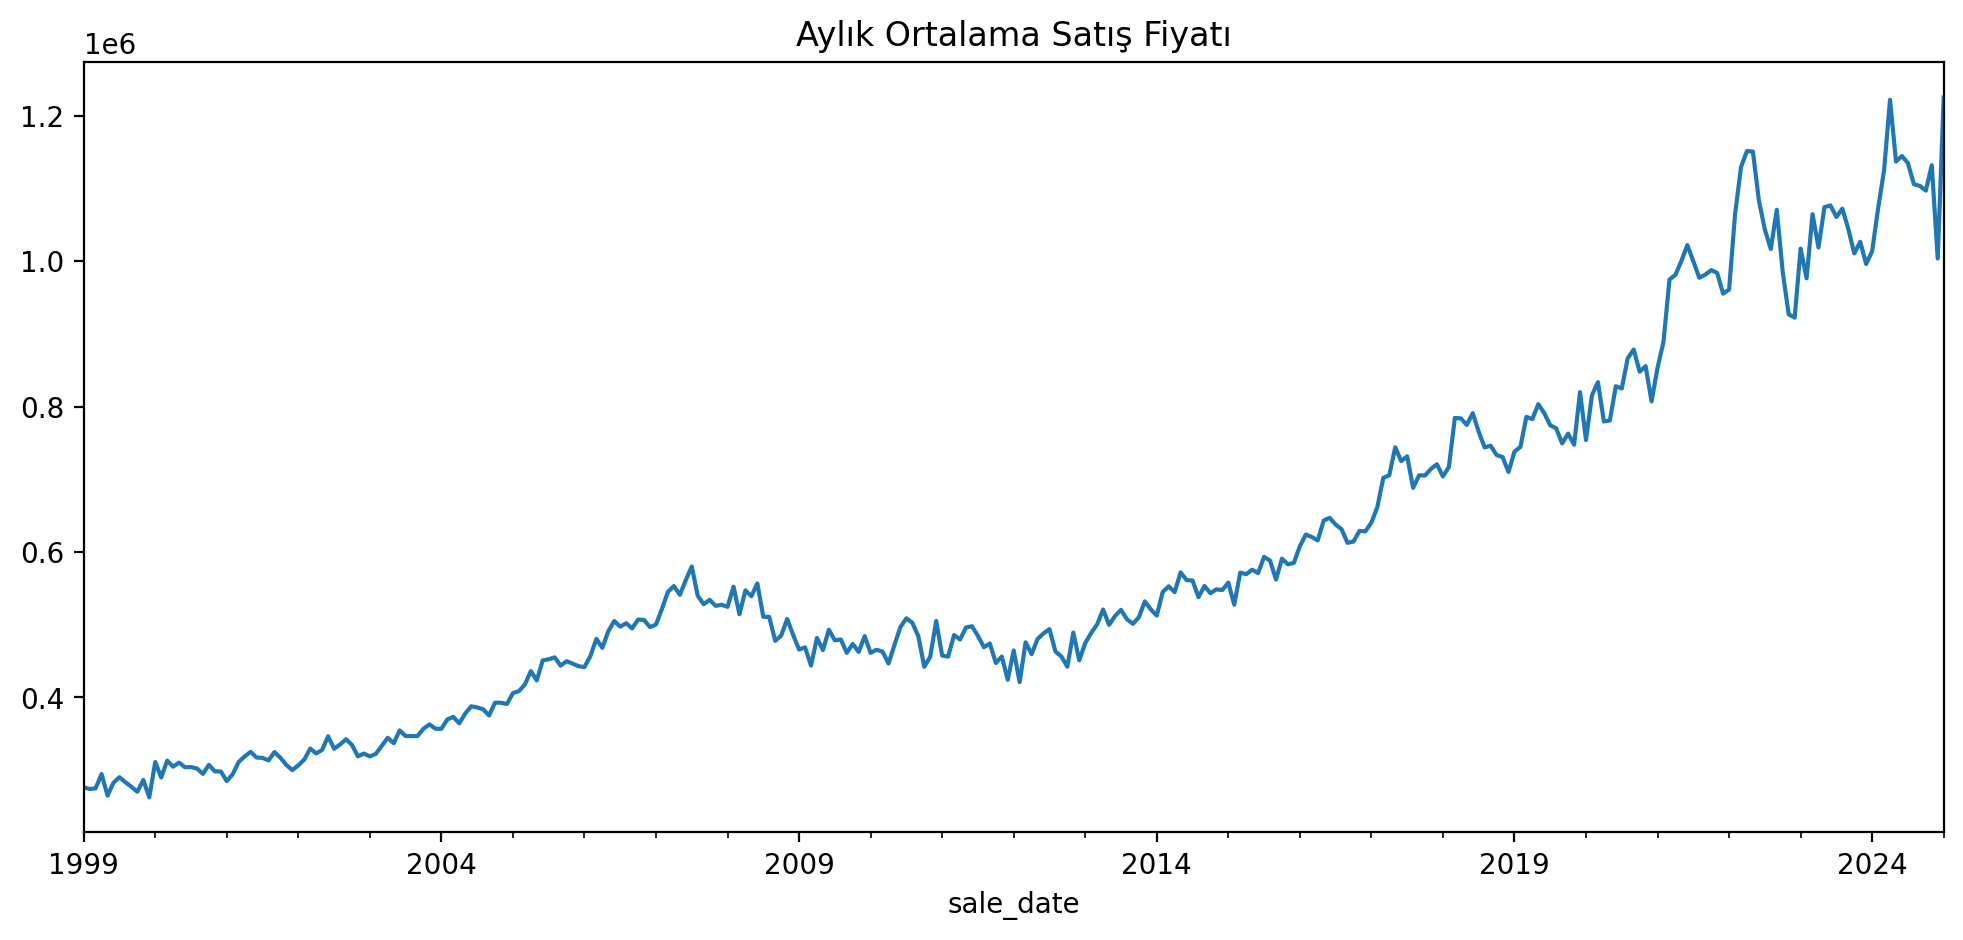

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hedef değişken dağılımı
plt.figure(figsize=(10, 5))
sns.histplot(train_data['sale_price'], bins=100, kde=True)
plt.title("Satış Fiyatı Dağılımı")
plt.xlabel("sale_price")
plt.show()

# Korelasyon ısı haritası
plt.figure(figsize=(14, 10))
sns.heatmap(train_data[features + ['sale_price']].corr(numeric_only=True)['sale_price'].sort_values(ascending=False).to_frame(), annot=True, cmap="coolwarm")
plt.title("Satış Fiyatı ile Korelasyon")
plt.show()

# Zaman serisi analizi
monthly_avg = train_data.groupby(train_data["sale_date"].dt.to_period("M"))["sale_price"].mean()
monthly_avg.plot(figsize=(12,5), title="Aylık Ortalama Satış Fiyatı")


In [12]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from lightgbm import early_stopping


X = train_data[features]
y = train_data["sale_price"]
X_test = test_data[features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[early_stopping(stopping_rounds=50)]
              )

    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(X_test) / kf.n_splits

rmse = mean_squared_error(y, oof_preds, squared=False)
print(f"✅ CV RMSE: {rmse:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 46
[LightGBM] [Info] Start training from score 584465.253519
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 105294	valid_0's l2: 1.10869e+10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3554
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 46
[LightGBM] [Info] Start training from score 584009.904463
Training un

In [13]:
submission = pd.read_csv(base_path / 'sample_submission.csv')
submission['sale_price'] = test_preds
submission.to_csv("submission.csv", index=False)
print("📥 Tahmin dosyası oluşturuldu: submission.csv")


📥 Tahmin dosyası oluşturuldu: submission.csv


In [14]:
import joblib

joblib.dump(model, "house_price_model.h5")
print("✅ Model kaydedildi: house_price_model.h5")


✅ Model kaydedildi: house_price_model.h5
